###  Add noise to images

process_image ./aces/ace_of_hearts.png
process_image ./aces/ace_of_clubs.png
process_image ./aces/ace_of_spades.png
process_image ./aces/ace_of_diamonds.png


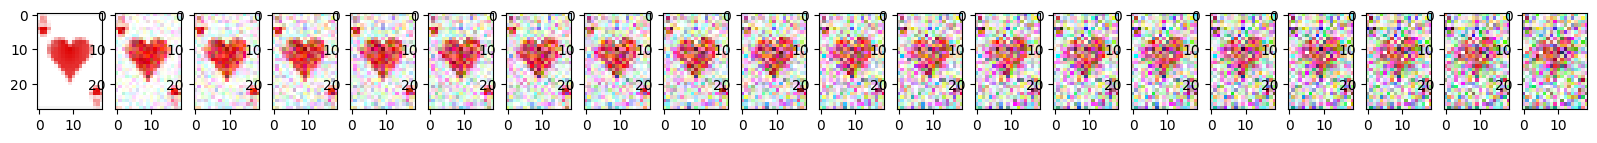

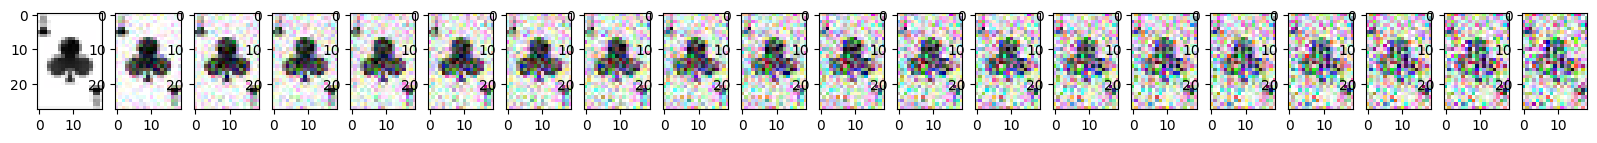

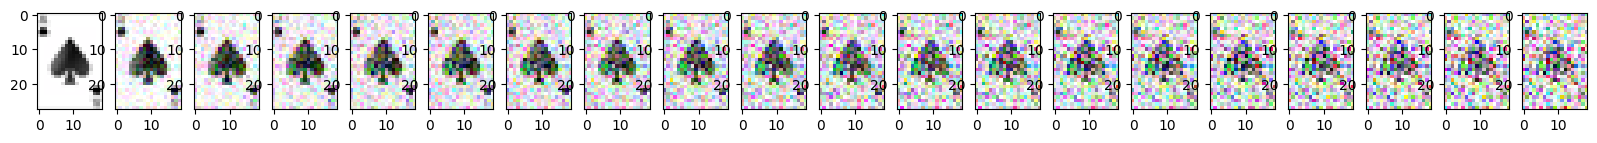

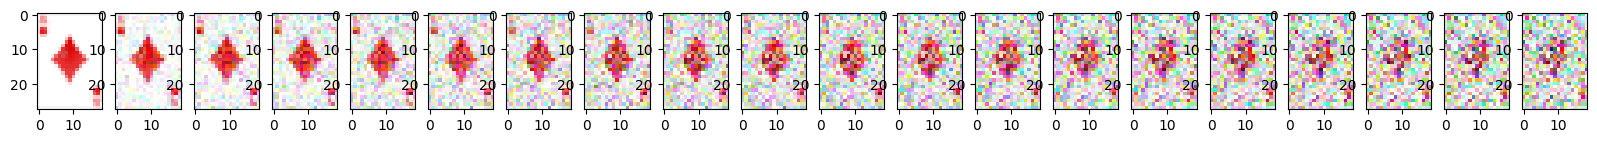

In [298]:
# Resize images using python 
import os 
from PIL import Image, ImageFilter
from multiprocessing import Pool
import numpy as np
import random
import matplotlib.pyplot as plt 
%matplotlib inline 

#Noise using torchvision
import torch
from torchvision import transforms
from torchvision.transforms import PILToTensor, Compose, ToPILImage, Resize, ToTensor
import pandas as pd 
import torchvision

def process_image(imgpath, target_size, target_path):
    print ("process_image", imgpath)
    img = Image.open(imgpath)
    new_image = img.resize(target_size)
    new_image.save(target_path, 'png', quality=100)

def resize(folder_path, target_size, target_folder="./temp/"):
    for item in os.listdir(folder_path):
        folder_path = folder_path if folder_path[-1] == '/' else folder_path+"/"
        src_path = folder_path + item
        if os.path.isfile(src_path) and src_path[-4:] == ".png":
            process_image(src_path, target_size, target_folder+item)

resize("./aces/", (19,28))

def add_noise_to_images(folder_path):
    folder_path = folder_path if folder_path[-1] == '/' else folder_path+"/"
    iters = 20
    for item in os.listdir(folder_path):
        images = []
        src_path = folder_path + item
        img = np.array(Image.open(src_path))

        for noise in range(0, iters):
            images.append(img)
            gn = np.random.normal(loc=0, scale=25, size=img.shape)
            img = np.clip(img + gn, 0, 255).astype(np.uint8)
        
        plt.figure(figsize=(20,15))
        columns = iters
        for i, image in enumerate(images):
            plt.subplot(len(images) // columns + 1, columns, i + 1)
            plt.imshow(image)

add_noise_to_images('./temp/')


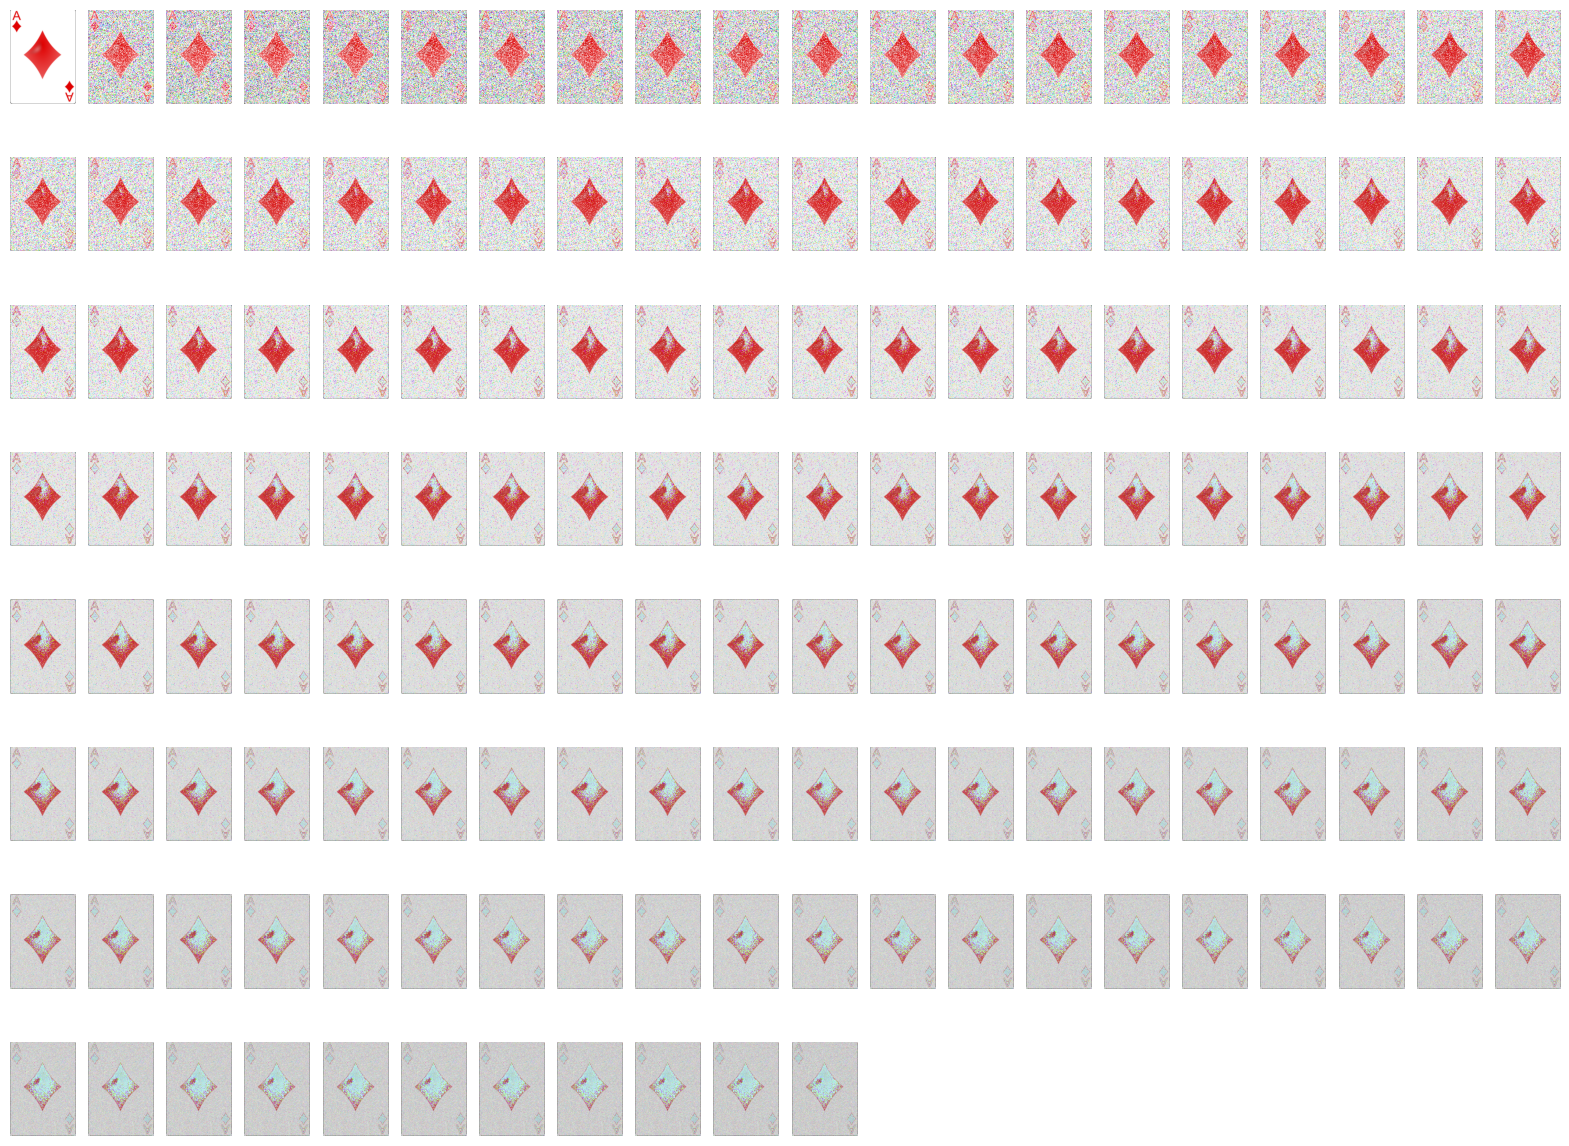

In [299]:
images = []
def gauss_noise_tensor(img):
    img_float = img.to(torch.float32)
    img_noised = img_float + 1.5*torch.randn(img.shape)
    img_noised = img_noised.to(img.dtype)
    output = ToPILImage()(img_noised)
    images.append(output)
    return output

tv = Compose([
        PILToTensor(),
        gauss_noise_tensor
    ]*150
)
input = Image.open("./aces/ace_of_diamonds.png")
input = Resize(150)(input)
images.append(input)
tv(input)

plt.figure(figsize=(20,15))
columns = 20

for i, image in enumerate(images):
    ax = plt.subplot(len(images) // columns + 1, columns, i + 1)
    ax.set_axis_off()
    plt.imshow(image)

### Linear noise schedule

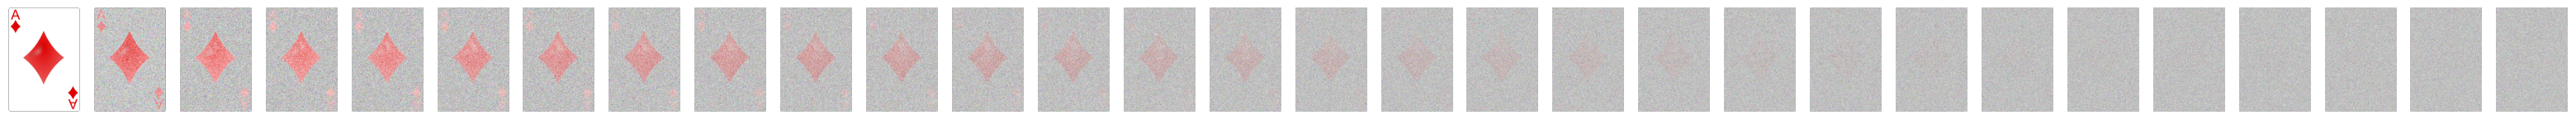

In [300]:
iters = 30
beta = torch.linspace(0.0001, 0.02, iters)
iters = len(beta)
alpha = [1-i for i in beta]
sqrt_1_minus_alpha = [np.sqrt(i) for i in alpha]

# schedule is based on sqrt_1_minus_alpha
input = Image.open("./aces/ace_of_diamonds.png")
input = ToTensor()(input)
images_linear_schedule = []

for bindex in range(iters):
    images_linear_schedule.append(ToPILImage()(input))
    alpha_bar = sqrt_1_minus_alpha[bindex]
    betav = beta[bindex]
    noise = torch.randn_like(input) * np.sqrt(betav)
    input = alpha_bar*input + noise

plt.figure(figsize=(40,20))
columns = 30

for i, image in enumerate(images_linear_schedule):
    ax = plt.subplot(len(images) // columns + 1, columns, i + 1)
    ax.set_axis_off()
    plt.imshow(image)
    

### Get directly image at iteration. 

By using the formula below, one can get the image iteration directly. 

$Q (X_t | X_{t-1} ) = N(\sqrt{\alpha_t.\alpha_{t-1}...\alpha_0}*X_{t-1} + \sqrt{1-\alpha_t.\alpha_{t-1}...\alpha_0}*\eta )  $


199


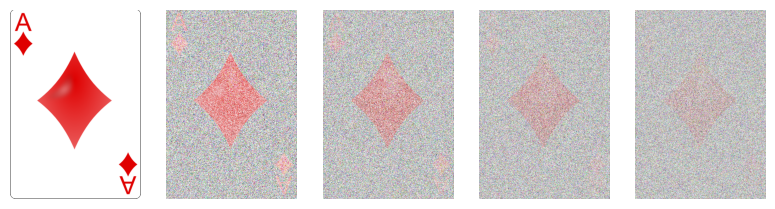

In [301]:
# image at certain step directly
input = Image.open("./aces/ace_of_diamonds.png")
input = ToTensor()(input)
iters = 300
beta = [i/10000 for i in range(1,int(0.02*10000), 1)]
iters = len(beta)
print (iters)
alpha = [1-i for i in beta]

def getImageAtIter(iters, input):
    alpha_val = 1

    for i in range(iters):
        alpha_val *= alpha[i]

    noise = torch.randn_like(input) * np.sqrt(1- alpha_val)
    input = np.sqrt(alpha_val)*input + np.sqrt(alpha_val) * noise
    return ToPILImage()(input)

plt.figure(figsize=(40,20))
columns = 20

images = [getImageAtIter(i, input) for i in [0, 10, 20, 30, 40]]
for i, image in enumerate(images):
    ax = plt.subplot(len(images) // columns + 1, columns, i + 1)
    ax.set_axis_off()
    plt.imshow(image)



### Cosine Schedule
References 

- https://arxiv.org/abs/2102.09672
- https://huggingface.co/blog/annotated-diffusion

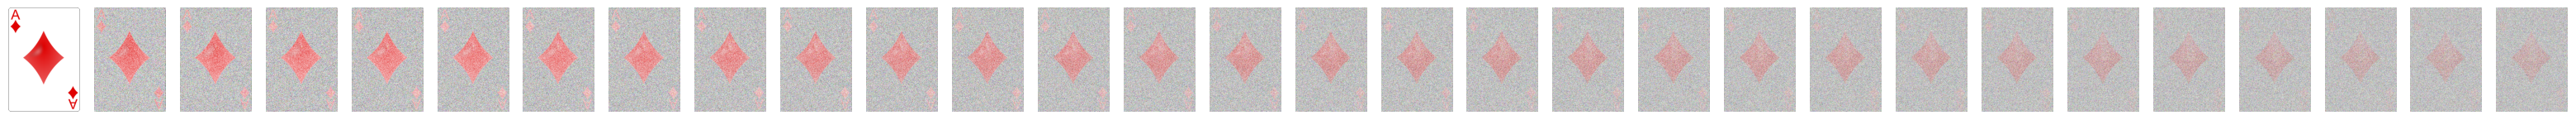

In [302]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in 
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

iters = 200
beta =  cosine_beta_schedule(iters)
alpha = 1. - beta
sqrt_1_minus_alpha = [np.sqrt(i) for i in alpha]

# schedule is based on sqrt_1_minus_alpha
input = Image.open("./aces/ace_of_diamonds.png")
input = ToTensor()(input)
images_cosine_schedule = []

for bindex in range(30):
    images_cosine_schedule.append(ToPILImage()(input))
    alpha_bar = sqrt_1_minus_alpha[bindex]
    betav = beta[bindex]
    noise = torch.randn_like(input) * np.sqrt(betav)
    input = alpha_bar*input + noise

plt.figure(figsize=(40,20))
columns = 30

for i, image in enumerate(images_cosine_schedule):
    ax = plt.subplot(len(images) // columns + 1, columns, i + 1)
    ax.set_axis_off()
    plt.imshow(image)
